# ACTIVITY RECOGNITION SYSTEM

## CSIS 3290 - 001 FUNDAMENTALS OF MACHINE LEARNING TERM PROJECT
### Student Name: Ibrahim Furkan Kocatepe
### Student ID: 300350918


## REFERENCES
- OS Module Documentation: https://docs.python.org/3/library/os.html

- Pandas Documentation: https://pandas.pydata.org/docs/index.html

- https://sparkbyexamples.com/pandas/pandas-filter-rows-with-nan-value-from-dataframe-column/#:~:text=You%20can%20filter%20out%20rows,represented%20as%20None%20or%20NaN.

- https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/

- https://www.datacamp.com/tutorial/pandas-read-csv

- https://seaborn.pydata.org/tutorial/color_palettes.html

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html

- https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349

## OVERVIEW OF MODULES THAT WERE NOT COVERED IN THE CLASS

#### OS MODULE:

 - The os module allows developers to interact with the operating system. It is especially useful for working with directories and file paths. 
 - In the case of this project, it was used for reading multiple CSV files at once that are placed under separate folders.
 - In this project, the following methods were used from the os module:
    - os.path.splitext: Splits the path name into two pieces of strings. 
    - os.path.join: Joins multiple paths and returns the concatenated string. 
    - os.listdir: Returns a list that holds names of the entries in specified directory.
 - OS Module Documentation: https://docs.python.org/3/library/os.html

#### OTHER METHODS AND CLASSES TO NOTE:

 - globals(): Returns a dictionary that contains all of the variables in the environment such as functions, classes, and modules.
 - imblearn.over_sampling.SMOTE(): SMOTE is an acronym for Synthetic Minority Over Sampling Technique. This class handles imbalanced data by creating synthetic instances of data. These new instances are similar to the existing data points but slightly different. 
    - SMOTE Documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

## INTRODUCTION

#### DATASET OVERVIEW:
Link to the dataset: https://archive.ics.uci.edu/dataset/366/activity+recognition+system+based+on+multisensor+data+fusion+arem
 - The dataset has 480 sequences, for a total of 42,240 instances. Each activity contains 15 RSS data temporal segments. It also takes into account two forms of bending exercise. Supplementary figures depict the sensor node placements and associated identifiers.
 - The raw data is processed to obtain time-domain characteristics. This process employs a 250-millisecond epoch time and collects 5 RSS samples from each pair of WSN nodes. Each reciprocal RSS reading's mean value and variance are among the attributes.
 - The visual below illustrates the positions of the sensors.

<img src=".\Dataset\sensorsPlacement.png" alt="sensorsPlacement" width="300"/>


#### PROBLEM OVERVIEW:
 - The dataset is intended for classifying user activity based on time-series data collected by a Wireless Sensor Network (WSN). This network measures the RSS (Received Signal Strength) of beacon packets transferred across WSN devices that have been altered by user movements. These IRIS nodes are worn on the user's chest and ankles.
 - The dataset is distributed to 7 folders, each folder contains data from measurements specific to each activity. The number of files in these folders range between 7 and 15. Each of the files contain data collected from the sensors in 120 seconds. By using this dataset, the project aims to create a model that will correctly classify the user's activity. 
 - The target activities are; bending1, bending2, cycling, lying, sitting, standing, and walking. The visual below shows the description of two bending activities:

<img src=".\Dataset\bendingType.png" alt="bendingType" width="600"/>


## SUMMARY OF STEPS

#### 1. DATA WRANGLING AND TRANSFORMATION:
 - The data was imported from each file using a for loop. 
 - After that, a general data cleaning process has been done. Specifically, one of the files is space delimited, unlike other files. Therefore, data obtained from that file was inaccurate. This problem was solved as well. 
 - A random sample was taken from the dataset to be used for out of sample prediction at the end.

#### 2. EXPLORATORY DATA ANALYSIS:
 - First three visuals were created for analyzing the distribution of features as well as the target classes in the dataframe.
 - The last visual was created for searching for strong correlations between features. 

#### 3. FEATURE ENGINEERING:
 - The target column was encoded using LabelEncoder in order to convert the values into numeric values so that it can be used when creating the machine learning models.
 - Outliers were removed by using 95th percentile as a threshold. 
 - The modified dataset was saved into a CSV file. 
 - Two degrees Polynomial Transformation with only interactions were performed. However, this step was included in the Pipeline, therefore, it is not visible under Feature Engineering title. In order to decide if Polynomial Transformation is necessary, an early model building stage was conducted. pipe_report() method was used for building the model with no transformation, and pipe_poly_report() method was used for building the model with transformation. Since the accuracy with Polynomial Transformation with 2 degrees and interaction only is highest, this strategy was followed.
 - As explained above, the data is imbalanced. SMOTE was used to solve this issue as a last step of Feature Engineering. 

#### 4. MODEL BUILDING:
 - Using pipe_poly_report() method, 7 classification models were created to compare which one performs better. 
 - XGBClassifier model performed best with an accuracy score over 85%. 

#### 5. HYPERPARAMETER TUNING AND CROSS VALIDATION:
 - Two rounds of three fold cross validation was conducted by using GridSearchCV. However, the accuracy did not improve significant enough to justify the computational cost. 
 - The best parameters turned out to be; learning_rate=0.1, colsample_bytree=0.7, n_estimators=1000, max_depth=7

#### 6. PREDICTIONS AND REPORT:
 - Predictions were made by using the best model found in the previous step. 
 - Classification report and a brief results analysis is included in this step.

#### 7. OUT OF SAMPLE PREDICTION:
 - The random sample taken in the earlier steps were used for out of sample prediction. 
 - The classification report for this prediction can be found under this step. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

## 1. DATA WRANGLING AND TRANSFORMATION

### Reading the Data

In [3]:
# Creating a list of directories to loop through
directories = ['./Dataset/bending1/', './Dataset/bending2/',
               './Dataset/cycling/', './Dataset/lying/',
               './Dataset/sitting/', './Dataset/standing/',
               './Dataset/walking/']

# Empty dictionary to hold dataframes
dfs = {}

# Looping through every file in the folder
# Note: Two CSV files originally contain an extra comma at the last row.
    # These commas were removed from the CSVs since they cause errors.
    # Therefore, please keep in mind that if you would like to run this code 
    # using the unmodified version of dataset, you will get errors when reading the data. 

for dir in directories:
    files = [f for f in os.listdir(dir) if f.endswith('.csv')]
    for file in files: 
        name = 'df_' + dir.replace('./Dataset/', '') + os.path.splitext(file)[0]
        dfs[name] = pd.read_csv(os.path.join(dir, file), skiprows=4)


# Looping through the dfs dictionary to extract all dataframes while assigning to different variables.
for key, value in dfs.items():
    new_key = key.replace('/dataset', '_')
    globals()[new_key] = value

In [4]:
# Adding 'activity' column to each dataframe
# Acitivities assigned by extracting them from each dataframe name
# This column will be the target
for name, df in dfs.items():
    df['activity'] = name.split('_')[1].split('/')[0]
    
# Concatenating all dataframes using the dfs dictionary
df = pd.concat(dfs, ignore_index=True)

In [5]:
print(df.head())

  # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0               0      39.25       0.43      22.75       0.43      33.75   
1             250      39.25       0.43      23.00       0.00      33.00   
2             500      39.25       0.43      23.25       0.43      33.00   
3             750      39.50       0.50      23.00       0.71      33.00   
4            1000      39.50       0.50      24.00       0.00      33.00   

   var_rss23  activity  
0        1.3  bending1  
1        0.0  bending1  
2        0.0  bending1  
3        0.0  bending1  
4        0.0  bending1  


In [6]:
# Displaying number of null values
df.isnull().sum()

# Columns: time      0
avg_rss12          480
var_rss12          480
avg_rss13          480
var_rss13          480
avg_rss23          480
var_rss23          480
activity             0
dtype: int64

In [7]:
# Finding the indexes of null values
df[~df.avg_rss12.notnull()]

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
4800,0 32.50 0.50 0.00 0.00 19.00 1.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
4801,250 32.50 0.50 0.00 0.00 18.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN,bending2
4802,500 32.75 0.43 1.00 0.00 18.00 0.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
4803,750 32.50 0.50 0.00 0.00 17.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN,bending2
4804,1000 32.50 0.50 7.50 0.50 17.50 0.87,NaN,NaN,NaN,NaN,NaN,NaN,bending2
...,...,...,...,...,...,...,...,...
5275,118750 28.67 0.47 4.67 1.25 17.33 0.47,NaN,NaN,NaN,NaN,NaN,NaN,bending2
5276,119000 27.50 0.50 5.50 2.50 17.25 1.30,NaN,NaN,NaN,NaN,NaN,NaN,bending2
5277,119250 28.00 0.00 6.67 0.94 17.00 1.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
5278,119500 28.00 0.00 5.00 0.82 17.00 0.71,NaN,NaN,NaN,NaN,NaN,NaN,bending2


 - Considering that each dataset has 480 rows, it is likely that one of the dataframes is full of null values.
 - The one with null values should be the 10th dataset which is dataset4 under bending2 folder.

In [8]:
df_bending2_4

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0 32.50 0.50 0.00 0.00 19.00 1.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
1,250 32.50 0.50 0.00 0.00 18.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN,bending2
2,500 32.75 0.43 1.00 0.00 18.00 0.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
3,750 32.50 0.50 0.00 0.00 17.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN,bending2
4,1000 32.50 0.50 7.50 0.50 17.50 0.87,NaN,NaN,NaN,NaN,NaN,NaN,bending2
...,...,...,...,...,...,...,...,...
475,118750 28.67 0.47 4.67 1.25 17.33 0.47,NaN,NaN,NaN,NaN,NaN,NaN,bending2
476,119000 27.50 0.50 5.50 2.50 17.25 1.30,NaN,NaN,NaN,NaN,NaN,NaN,bending2
477,119250 28.00 0.00 6.67 0.94 17.00 1.00,NaN,NaN,NaN,NaN,NaN,NaN,bending2
478,119500 28.00 0.00 5.00 0.82 17.00 0.71,NaN,NaN,NaN,NaN,NaN,NaN,bending2


In [9]:
# Reading the dataset again, this time using space as delimiter
dfs['df_bending2/dataset4'] = pd.read_csv('./Dataset/bending2/dataset4.csv', sep='\s+', names=df_bending1_1.columns, skiprows=5)

# Passing 'bending2' value to activity column again
dfs['df_bending2/dataset4']['activity'] = 'bending2'

# Concatenating the dataframes again
df = pd.concat(dfs, ignore_index=True)

# Renaming the first column to 'time'
df.rename(columns={'# Columns: time': 'time'}, inplace=True)

# Double checking
df.isnull().sum()

time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
activity     0
dtype: int64

In [10]:
# Taking a random sample of 200 rows from the dataframe to use it for out of sample prediction later
df_oos = df.sample(n=200, random_state=42)

# Removing the sample from the original dataframe
df = df.drop(df_oos.index)

## 2. EXPLORATORY DATA ANALYSIS

In [11]:
# Summary statistics
df.describe()

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,42039.000000,42039.00000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000
mean,59865.226337,38.91439,1.459735,14.278259,1.502136,16.032553,1.620917
std,34645.759929,6.33871,2.048978,5.434413,1.638577,6.731289,1.637951
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29750.000000,35.00000,0.400000,11.330000,0.430000,12.000000,0.470000
50%,59750.000000,39.75000,0.500000,15.000000,0.830000,16.000000,1.000000
75%,89750.000000,43.75000,1.790000,18.000000,2.290000,19.250000,2.290000
max,119750.000000,56.25000,17.240000,35.000000,11.420000,40.330000,13.610000


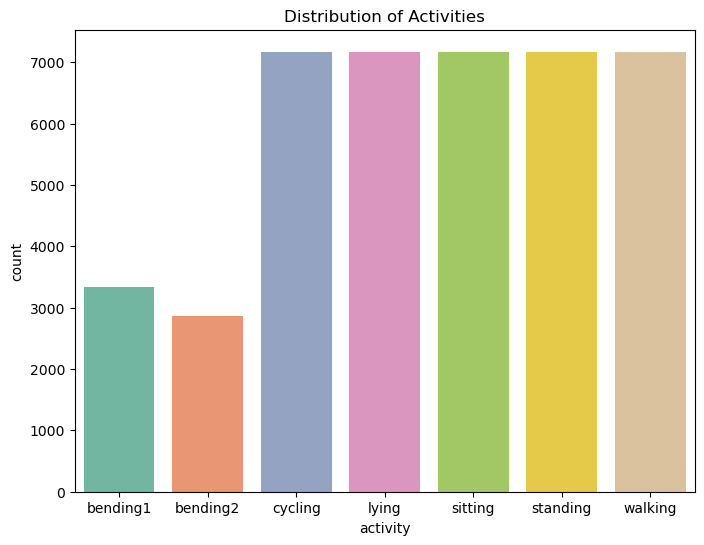

In [12]:
# Plotting the distribution of each activity
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='activity', palette='Set2')
plt.title('Distribution of Activities')
plt.show()

### Observations: 
    - Except bending1 and bending2, it appears that the number of data points is around the same for each activity.
    - There is an imbalance between bending activities and the rest.
    - When we add up bending activities together, we end up with 6240 data points which is very close to other activities.
    - However, bending activities should not be combined together for the purposes of this project.

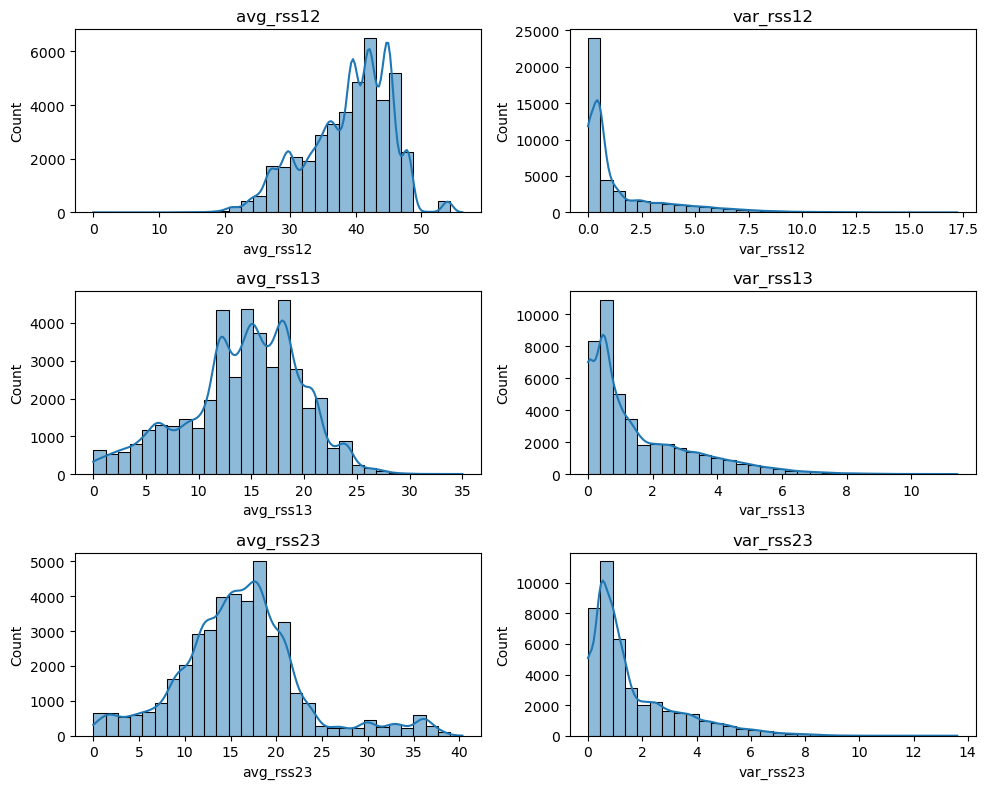

In [13]:
# Plotting the distribution of each variable
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

axs = axs.flatten()

for ax, col in zip(axs, df.select_dtypes(exclude=['object', 'int']).columns):
    sns.histplot(df[col], ax=ax, kde=True, bins=30)
    ax.set_title(col)

plt.tight_layout()

### Observations:
    - Average RSS values seems to be very close to normal distribution.
    - On the other hand, Variance RSS values are mostly right skewed. It can be seen that most of the values are very small, meaning that the variance of RSS values tend to be smaller. This is a good sign since it indicates that the data is not spreaded widely.
    - It looks like there is a lot of outliers in Average and Variance RSS values. Removing those outliers can help the model to perform better. 
    - Different approaches to removing outliers will be taken in the later stages.

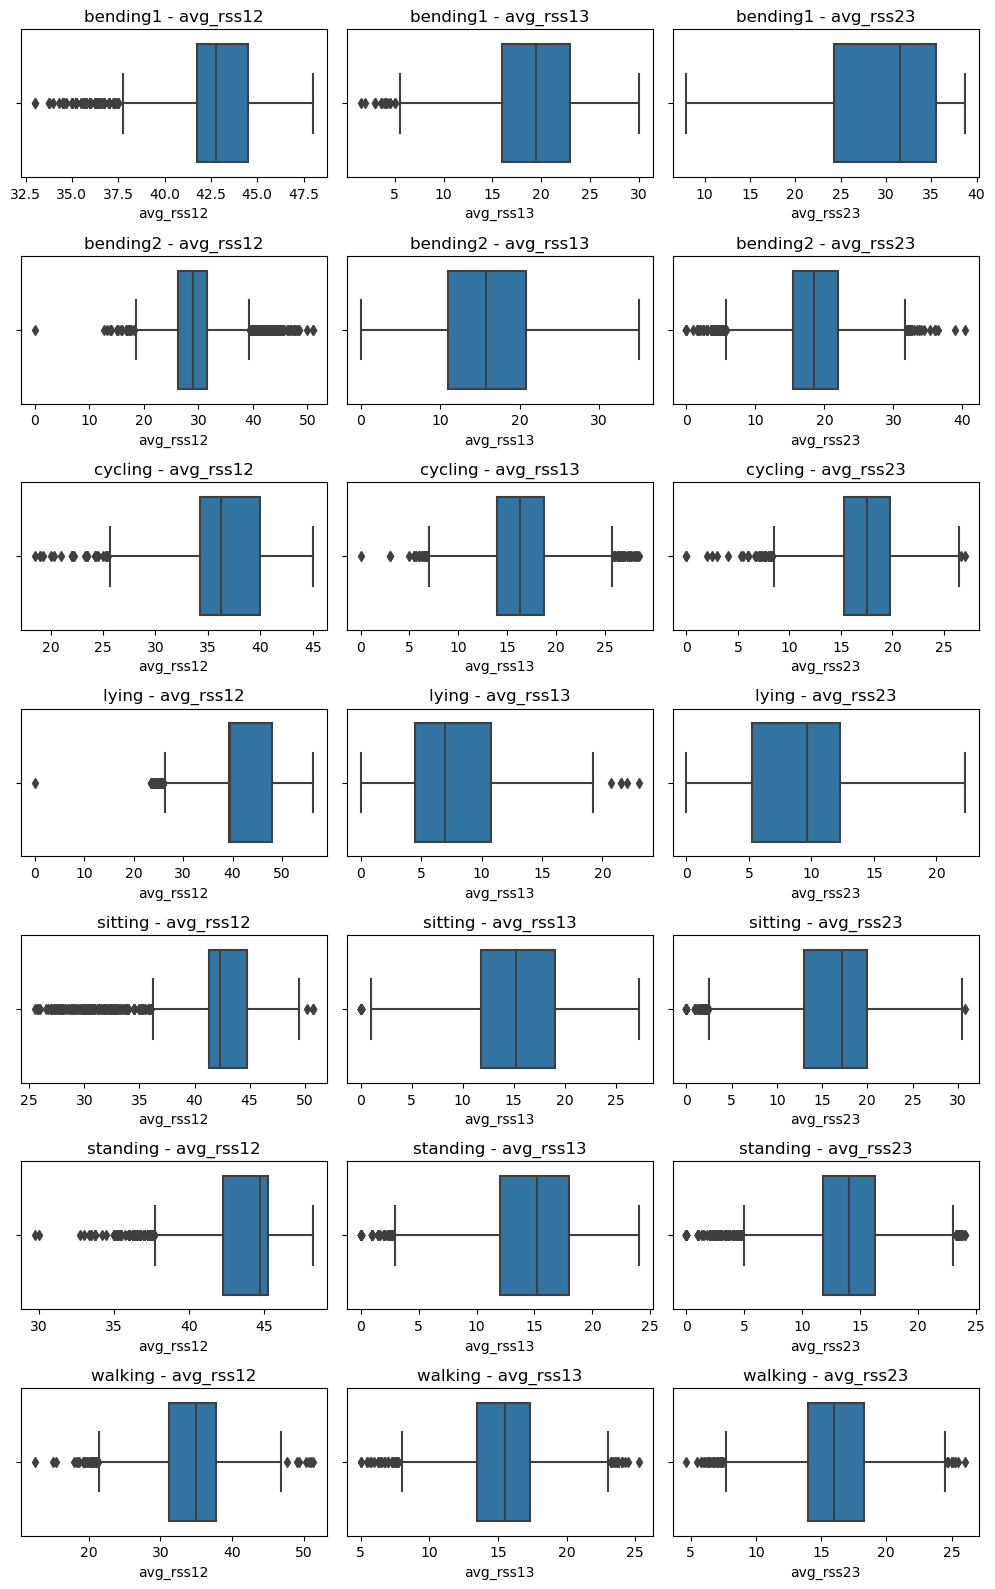

In [14]:
# Displaying boxplots of avg rss values for each activity
activities = df['activity'].unique()
cols = [col for col in df.columns if 'avg' in col]

fig, axs = plt.subplots(7, 3, figsize=(10, 16))

for i, activity in enumerate(activities):
    df_activity = df[df['activity'] == activity]
    for j, col in enumerate(cols):
        sns.boxplot(x=df_activity[col], ax=axs[i, j])
        axs[i, j].set_title(f'{activity} - {col}')

plt.tight_layout()
plt.show()

### Observations:
    - Illustrations above present that most of the activities have a distribution close to normal which is a good sign.
    - However, some of the avg_rss12 distributions are not distributed normally: bending1, cycling, lying, sitting, and standing. 
    - Also, in avg_rss12 column, there appears to be a lot of outliers. 

<Axes: >

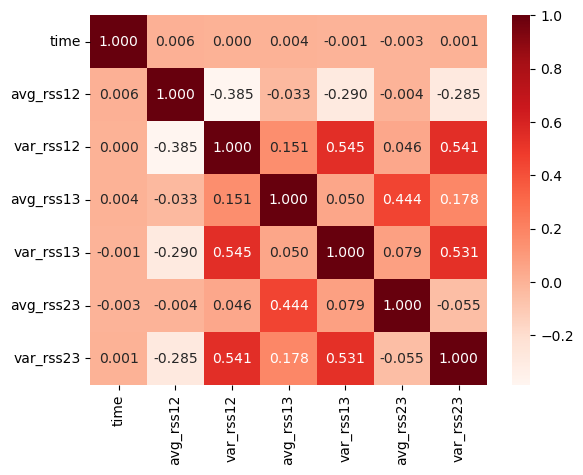

In [15]:
# Displaying the correlations between variables
sns.heatmap(df.select_dtypes(exclude=['object']).corr(), annot=True, fmt='.3f', cmap='Reds')

### Observations:
    - It seems that there is no strong correlation between variables.
    - Relatively stronger correlations are observed between Variance RSS values.

## 3. FEATURE ENGINEERING

In [16]:
%run Functions/functions.ipynb

In [17]:
# Converting the target variable into a numeric variable using LabelEncoder
df['activity_labeled'] = label_encoder(df['activity'])

In [18]:
# Removing Outliers
df = df[df['avg_rss12'] < df['avg_rss12'].quantile(0.95)]
df = df[df['avg_rss13'] < df['avg_rss13'].quantile(0.95)]
df = df[df['avg_rss23'] < df['avg_rss23'].quantile(0.95)]

In [19]:
# Saving the modified dataframe to a CSV file
df.to_csv('dataset_modified.csv', index=False)

    - Polynomial Transformation is performed in the pipeline.

In [27]:
# Creating features and target dataframes
features = df.drop(['activity', 'activity_labeled'], axis=1)
target = df['activity_labeled']

# Balancing the data using Imblearn Smote
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(features,target) 
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.25, random_state=42)

    - Since the number of data points in each class is inbalanced, balancing the data will help improve the performance of the model.

## 4. MODEL BUILDING

In [21]:
# Creating a list of classification models to pass into the Pipeline
models = [KNeighborsClassifier(3), LinearSVC(max_iter=5000, random_state=42), SVC(kernel='rbf', gamma='auto', random_state=42),
            DecisionTreeClassifier(max_depth=5, random_state=42), RandomForestClassifier(random_state=42), 
            XGBClassifier(random_state=42), CatBoostClassifier(random_state=42)]

# By calling the pipe_poly method, we iterate through different classification models that are placed in the pipeline using the balanced data
# The method returns a dataframe that holds the accuracy scores of each model
df_pipe_poly = pipe_poly_report(X_balanced, y_balanced, models)

c:\Users\Furkan\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.09516
0:	learn: 1.6942715	total: 215ms	remaining: 3m 34s
1:	learn: 1.5296440	total: 269ms	remaining: 2m 14s
2:	learn: 1.4019249	total: 327ms	remaining: 1m 48s
3:	learn: 1.3026579	total: 378ms	remaining: 1m 34s
4:	learn: 1.2220710	total: 426ms	remaining: 1m 24s
5:	learn: 1.1596062	total: 474ms	remaining: 1m 18s
6:	learn: 1.1030355	total: 524ms	remaining: 1m 14s
7:	learn: 1.0530958	total: 575ms	remaining: 1m 11s
8:	learn: 1.0117707	total: 626ms	remaining: 1m 8s
9:	learn: 0.9746473	total: 692ms	remaining: 1m 8s
10:	learn: 0.9392522	total: 758ms	remaining: 1m 8s
11:	learn: 0.9097974	total: 817ms	remaining: 1m 7s
12:	learn: 0.8821690	total: 880ms	remaining: 1m 6s
13:	learn: 0.8587632	total: 960ms	remaining: 1m 7s
14:	learn: 0.8349897	total: 1.05s	remaining: 1m 8s
15:	learn: 0.8153624	total: 1.11s	remaining: 1m 8s
16:	learn: 0.7972655	total: 1.18s	remaining: 1m 8s
17:	learn: 0.7805810	total: 1.25s	remaining: 1m 8s
18:	learn: 0.7656277	total: 1.33s	remaining: 1m 8s
19:	

In [22]:
# Displaying the accuracy scores of each model
df_pipe_poly

,Model,Accuracy
5,XGBClassifier,0.853382
4,RandomForestClassifier,0.850966
6,CatBoostClassifier,0.846538
0,KNeighborsClassifier,0.806441
2,SVC,0.774557
1,LinearSVC,0.713446
3,DecisionTreeClassifier,0.694203


    - It can be seen that the best performing model is XGBoostClassifier.

In [28]:
# Building the XGBoost model with default parameters
xgb = XGBClassifier(random_state=42)
pipe_xgb = pipe_poly(X_train, y_train, xgb)

In [29]:
# Making the prediction and displaying the classification report
pred_xgb = pipe_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1705
           1       0.97      0.97      0.97      1804
           2       0.69      0.70      0.70      1819
           3       0.97      0.98      0.98      1713
           4       0.82      0.76      0.79      1771
           5       0.81      0.82      0.82      1788
           6       0.73      0.74      0.73      1820

    accuracy                           0.85     12420
   macro avg       0.85      0.85      0.85     12420
weighted avg       0.85      0.85      0.85     12420



## 5. HYPERPARAMETER TUNING AND CROSS VALIDATION

In [23]:
# First round of cross validation using GridSearchCV
model = XGBClassifier(random_state=42)

params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.03, 0.1],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

gs_cv = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs_cv.fit(X_train, y_train)

print(gs_cv.best_score_)
print(gs_cv.best_params_)

0.8406022653201766
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [29]:
# Second round of cross validation using GridSearchCV
model = XGBClassifier(learning_rate=0.1, colsample_bytree=0.7,random_state=42)

params = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [5, 6, 7]
}

gs_cv = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs_cv.fit(X_train, y_train)

print(gs_cv.best_score_)
print(gs_cv.best_params_)

0.8503716795516644
{'max_depth': 7, 'n_estimators': 1000}


## 6. PREDICTIONS AND REPORT

In [46]:
# Assigning the best estimator to a variable to pass into the pipeline
model = gs_cv.best_estimator_

# Building the best model
best_model = pipe_poly(X_train, y_train, model)

y_pred = best_model.predict(X_test)

In [47]:
# Displaying the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1397
           1       0.97      0.97      0.97      1499
           2       0.72      0.73      0.72      1432
           3       0.98      0.99      0.98      1358
           4       0.85      0.81      0.83      1392
           5       0.86      0.85      0.86      1356
           6       0.75      0.76      0.76      1452

    accuracy                           0.87      9886
   macro avg       0.87      0.87      0.87      9886
weighted avg       0.87      0.87      0.87      9886



In [32]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Assigning the activity classes to cm_labels to display in the heatmap
cm_labels = df['activity'].unique()

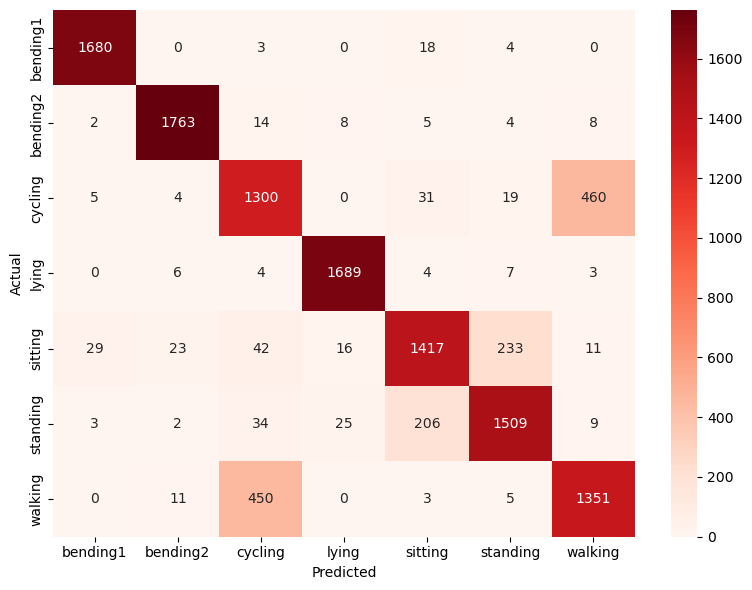

In [42]:
# Displaying the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='.0f', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

### Results Analysis:
 - Overall, the model performed good when classifying activities. 
 - Classes 0 (bending1), 1 (bending2) and 3 (lying) have extremely good precision, recall, and F1-score (all greater than 0.97). This indicates that the model is good at predicting these classes, with few false positives or false negatives.
 - Classes 2 (cycling), 4 (sitting), 5 (standing), and 6 (walking) have lower scores than the preceding classes. Class 2 has the lowest scores, with precision, recall, and F1-scores all around 0.70. This implies that the model is having trouble correctly classifying this class, as demonstrated by a higher frequency of false positives and false negatives. Classes 4, and 5 have intermediate scores, indicating that they are performing moderately. 
 - As can be seen in the confusion matrix above, the model inaccurately classified walking as cycling and vice versa. 
 - The model's overall accuracy is 0.87, implying that 87% of the total instances were properly classified. The macro and weighted averages for precision, recall, and F1-score are also 0.87, showing that performance is balanced across all classes (weighted average).

## 7. OUT OF SAMPLE PREDICTION

In [40]:
# Dividing the out of sample data into features and target
# df_oos was created in the data wrangling and transfomation part by taking random samples from the original data
X_val = df_oos.drop(['activity', 'activity_labeled'], axis=1)
y_val = df_oos['activity_labeled']

# Running the model with validation data
val_pred = best_model.predict(X_val)

In [41]:
# Displaying the classification report
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       0.94      0.76      0.84        38
           3       1.00      1.00      1.00        37
           4       0.89      0.95      0.92        41
           5       0.94      0.89      0.91        36
           6       0.81      0.94      0.87        36

    accuracy                           0.92       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.92      0.92      0.91       200



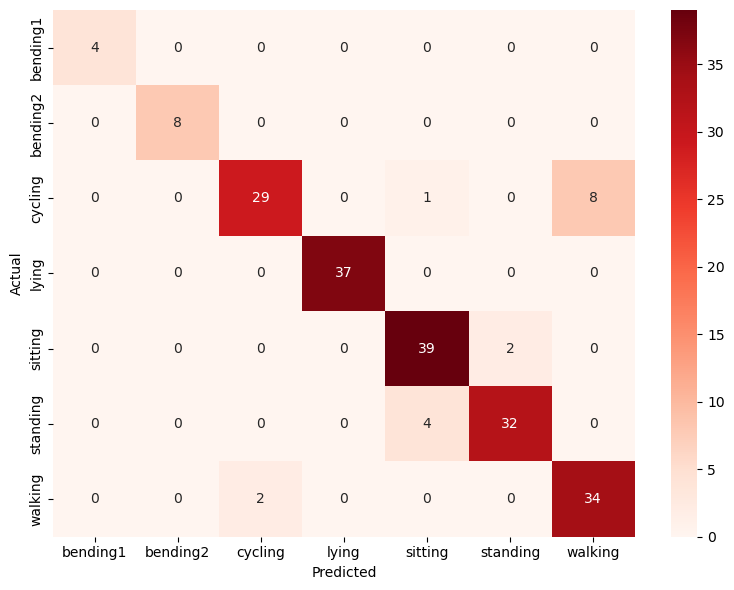

In [54]:
# Creating the confusion matrix
cm_val = confusion_matrix(y_val, val_pred)

# Displaying the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_val, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='.0f', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()